# Importing Packages

In [ ]:
!pip install aisdc

In [1]:
import os
import sys
import pylab as plt
import numpy as np
import logging
import importlib
import argparse
import json
import pickle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score
from os.path import expanduser
from aisdc.safemodel.classifiers import SafeSVC
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_privacy as tf_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from aisdc.safemodel.classifiers import SafeKerasModel
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_privacy as tf_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from aisdc.attacks.attack_report_formatter import (  # pylint: disable=import-error
    GenerateTextReport,
)
from aisdc.attacks.likelihood_attack import LIRAAttack  # pylint: disable=import-error
from aisdc.attacks.target import Target  # pylint: disable=import-error
from aisdc.attacks.worst_case_attack import (  # pylint: disable=import-error
    WorstCaseAttack,
)


from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.metrics.privacy.worst_case_mia_score import get_roc_for_fpr
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data preperation

## Loading train data

In [2]:
train_data = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv')
train_data = train_data.drop(columns=['Unnamed: 0', 'session_id', 'examination_date', 'earliest_time','rh.aparc.volume','lh.aparc.volume'])
train_data = train_data.drop(columns=['participant_id', 'Measure:volume'])
diagnosis_mapping = {'MCI': 2, 'CN': 0, 'AD': 1, 0.666667: 0}
train_data['diagnosis'] = train_data['diagnosis'].map(diagnosis_mapping)
train_data = train_data[(train_data['diagnosis'] == 0) | (train_data['diagnosis'] == 1)]

## Loading test data

In [3]:
test_data = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_test_volumes.tsv')
test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'session_id','participant_id','rh.aparc.volume','lh.aparc.volume'])
diagnosis_mapping = {'MCI': 2, 'CN': 0, 'AD': 1}
test_data['diagnosis'] = test_data['diagnosis'].map(diagnosis_mapping)
test_data = test_data[(test_data['diagnosis'] == 0) | (test_data['diagnosis'] == 1)]

## Cleaning data

In [4]:
# Making sure both train and test having same features
common_columns = set(train_data.columns).intersection(set(test_data.columns))
train_data = train_data[common_columns]
test_data = test_data[common_columns]

In [5]:
# Imputing missing values using KNN
imputer = KNNImputer(n_neighbors=3)
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)

## Split data

In [6]:
X_train = train_data.drop(columns=['diagnosis'])
X_test = test_data.drop(columns=['diagnosis'])
y_train = train_data['diagnosis']
y_test = test_data['diagnosis']

## Normalising data

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Set Seed

In [8]:
SEED = 12345

# Baseline Models

## SVM Model

### SVM Hyperparameter Optimisation

In [11]:
svm = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
    'probability': [True]
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1',verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.3s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.3s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.4s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.5s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.5s
[CV] END ...C=0.1, gamma=0.001, kernel=rbf, probability=True; total time=   0.5s
[CV] END ...C=0.1, gamma=0.001, kernel=rbf, pro

In [12]:
print(best_params)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}


In [13]:
print(best_score)

0.8712065594899391


### Final SVM Model & Evaluation

In [9]:
clf = SVC(kernel='rbf', gamma='scale', C=10, probability=True)
clf.fit(X_train_scaled, y_train)
predictions = clf.predict(X_test_scaled)

In [10]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
f1 = f1_score(y_test, predictions)
print(f"F1-Score: {f1}")

Accuracy: 0.9301075268817204
F1-Score: 0.9326424870466321


In [11]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[83,  6],
       [ 7, 90]], dtype=int64)

### Save Model and Data

In [256]:
directory = "./SVM_unsafe"
print("Saving training/testing data to " + directory)
np.savetxt(os.path.join(directory, "x_train.txt"), X_train_scaled, fmt="%d")
np.savetxt(os.path.join(directory, "y_train.txt"), y_train, fmt="%d")
np.savetxt(os.path.join(directory, "x_test.txt"), X_test_scaled, fmt="%d")
np.savetxt(os.path.join(directory, "y_test.txt"), y_test, fmt="%d")

Saving training/testing data to ./1


In [257]:
filename = os.path.join(directory, "model.pkl")
print("Saving model to " + filename)
with open(filename, "wb") as file:
    pickle.dump(clf, file)

Saving model to ./1\model.pkl


### Attack

In [261]:
def generate_report(directory, target_model, x_train, y_train,
                                             x_test, y_test, 
                    attack_output_name, target_filename, outfile,):  # pylint: disable=too-many-arguments, disable=too-many-locals
    """Generate report based on target model."""

    print()
    print("Acting as TRE...")
    print()

    if not os.path.exists(directory):
        os.makedirs(directory)

    # Suppress messages from AI-SDC -- comment out these lines to
    # see all the aisdc logging statements
    logging.getLogger("attack-reps").setLevel(logging.WARNING)
    logging.getLogger("prep-attack-data").setLevel(logging.WARNING)
    logging.getLogger("attack-from-preds").setLevel(logging.WARNING)

    # Read the model to be released as supplied by the researcher
    model_filename = os.path.join(directory, target_model)
    print("Reading target model from " + model_filename)
    with open(model_filename, "rb") as file:
        target_model = pickle.load(file)

    # Read the training/testing data as supplied by the researcher
    print("Reading training/testing data from " + directory)
    train_x = np.loadtxt(os.path.join(directory, x_train))
    train_y = np.loadtxt(os.path.join(directory, y_train))
    test_x = np.loadtxt(os.path.join(directory, x_test))
    test_y = np.loadtxt(os.path.join(directory, y_test))

    # Wrap the training and test data into the Target object
    target = Target(model=target_model)
    target.add_processed_data(train_x, train_y, test_x, test_y)

    # Run the attack
    wca = WorstCaseAttack(
        n_dummy_reps=10, output_dir=directory, report_name=attack_output_name
    )
    wca.attack(target)

    _ = wca.make_report()

    # Define a configuration file for the attacks to be run
    lira_config = {
        "training_data_filename": "train_data.csv",
        "test_data_filename": "test_data.csv",
        "training_preds_filename": "train_preds.csv",
        "test_preds_filename": "test_preds.csv",
        "target_model": ["sklearn.svm"],
        "target_model_hyp": {"C": 10, "gamma": 'scale'},
    }

    with open(
        os.path.join(directory, "lira_config.json"), "w", encoding="utf-8"
    ) as file:
        file.write(json.dumps(lira_config))

    # Run the LIRA attack to test disclosure risk
    lira_attack_obj = LIRAAttack(
        n_shadow_models=100,
        attack_config_json_file_name=os.path.join(directory, "lira_config.json"),
        output_dir=directory,
        report_name=attack_output_name,
    )

    lira_attack_obj.attack(target)
    _ = lira_attack_obj.make_report()

    target.save(os.path.join(directory, "target"))

    text_report = GenerateTextReport()
    text_report.process_attack_target_json(
        os.path.join(directory, attack_output_name) + ".json",
        target_filename=os.path.join(directory, "target", target_filename),
    )

    text_report.export_to_file(
        output_filename=os.path.join(directory, outfile),
        move_files=True,
        model_filename=model_filename,
    )

    print("Results written to " + os.path.join(directory, outfile))

In [262]:
def run_user_story(release_config: dict):
    """Main method to parse arguments and then invoke report generation."""

    generate_report(
        release_config["training_artefacts_dir"],
        release_config["target_model"],
        release_config["x_train_path"],
        release_config["y_train_path"],
        release_config["x_test_path"],
        release_config["y_test_path"],
        release_config["attack_output_name"],
        release_config["target_results"],
        release_config["outfile"],
    )


Acting as TRE...

Reading target model from ./1\model.pkl
Reading training/testing data from ./1


INFO:_check_and_update_dataset:new ytrain has values and counts: (array([0, 1]), array([567, 527], dtype=int64))
INFO:_check_and_update_dataset:new ytest has values and counts: (array([0, 1]), array([89, 97], dtype=int64))
INFO:lr-scenario:Training shadow models
INFO:lr-scenario:Trained 0 models
INFO:lr-scenario:Trained 10 models
INFO:lr-scenario:Trained 20 models
INFO:lr-scenario:Trained 30 models
INFO:lr-scenario:Trained 40 models
INFO:lr-scenario:Trained 50 models
INFO:lr-scenario:Trained 60 models
INFO:lr-scenario:Trained 70 models
INFO:lr-scenario:Trained 80 models
INFO:lr-scenario:Trained 90 models
INFO:lr-scenario:Computing scores for train rows
INFO:lr-scenario:Computing scores for shadow rows
INFO:lr-scenario:Finished scenario
INFO:reporting:Starting reports, pdf report name = ./1\attack_output.pdf, json report name = ./1\attack_output.json
INFO:reporting:Wrote pdf report to ./1\attack_output.pdf and json report to ./1\attack_output.json


Results written to ./1\summary.txt


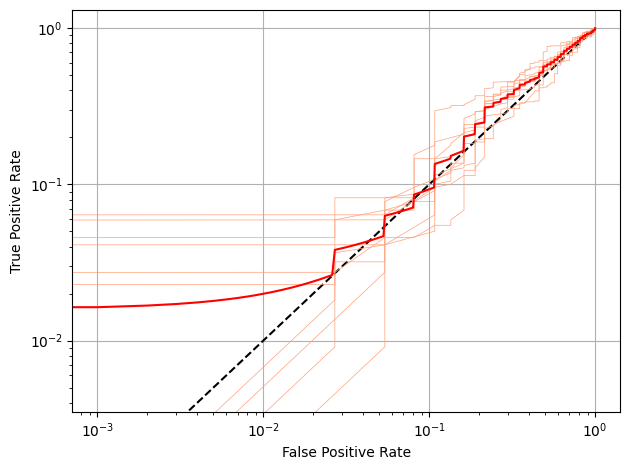

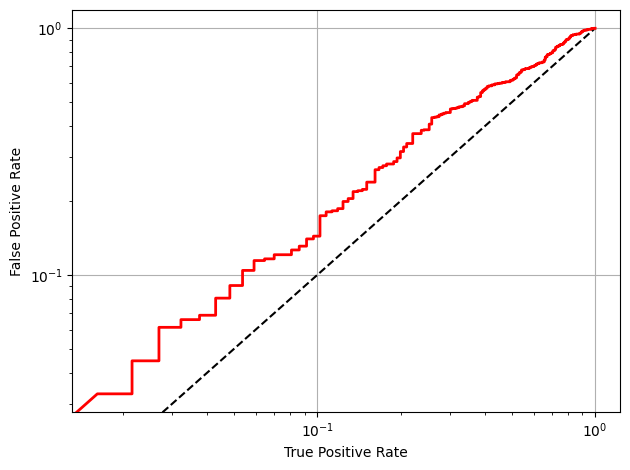

In [263]:
config = {
    'user_story': 3,
    'dataset_filename': 'C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv',
    'target_model': "model.pkl",
    'outfile': "summary.txt",
    'attack_results': "attack_results.json",
    'training_artefacts_dir': "./SVM_unsafe",
    'target_results': "target.json",
    'x_train_path': "x_train.txt",
    'y_train_path': "y_train.txt",
    'x_test_path': "x_test.txt",
    'y_test_path': "y_test.txt",
    'attack_output_name': "attack_output"
}

run_user_story(config)

### Adversarial Robustness Toolbox MI Attack

In [13]:
art_classifier = ScikitlearnSVC(clf)

attack = MembershipInferenceBlackBoxRuleBased(art_classifier)

# infer attacked feature
inferred_train = attack.infer(X_train_scaled, y_train)
inferred_test = attack.infer(X_test_scaled, y_test)

# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

Members Accuracy: 1.0000
Non Members Accuracy 0.0699
Attack Accuracy 0.8648


In [15]:
attack_train_ratio = 0.5
attack_train_size = int(len(X_train_scaled) * attack_train_ratio)
attack_test_size = int(len(X_test_scaled) * attack_train_ratio)

bb_attack = MembershipInferenceBlackBox(art_classifier)

# train attack model
bb_attack.fit(X_train_scaled[:attack_train_size], y_train[:attack_train_size],
              X_test_scaled[:attack_test_size], y_test[:attack_test_size])

# get inferred values
inferred_train_bb = bb_attack.infer(X_train_scaled[attack_train_size:], y_train[attack_train_size:])
inferred_test_bb = bb_attack.infer(X_test_scaled[attack_test_size:], y_test[attack_test_size:])

# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

Members Accuracy: 1.0000
Non Members Accuracy 0.0000
Attack Accuracy 0.8547


In [17]:
# we run the worst case metric on trainset to find an appropriate threshold
# Black Box
bb_members_test_prob = bb_attack.infer(X_train_scaled[attack_train_size:].astype(np.float32), y_train[attack_train_size:], probabilities=True)
bb_nonmembers_test_prob = bb_attack.infer(X_test_scaled[attack_test_size:].astype(np.float32), y_test[attack_test_size:], probabilities=True)

bb_mia_test_probs = np.concatenate((np.squeeze(bb_members_test_prob, axis=-1),
                               np.squeeze(bb_nonmembers_test_prob, axis=-1)))
                              
bb_mia_test_labels = np.concatenate((np.ones_like(y_train[:attack_train_size]), np.zeros_like(y_test[:attack_test_size])))
# We allow 1% FPR 
fpr, tpr, threshold = get_roc_for_fpr(attack_proba=bb_mia_test_probs, attack_true=bb_mia_test_labels, targeted_fpr=0.01)[0]
print(f'{tpr=}: {fpr=}: {threshold=}')

tpr=0.016453382084095063: fpr=0.0: threshold=0.8793742


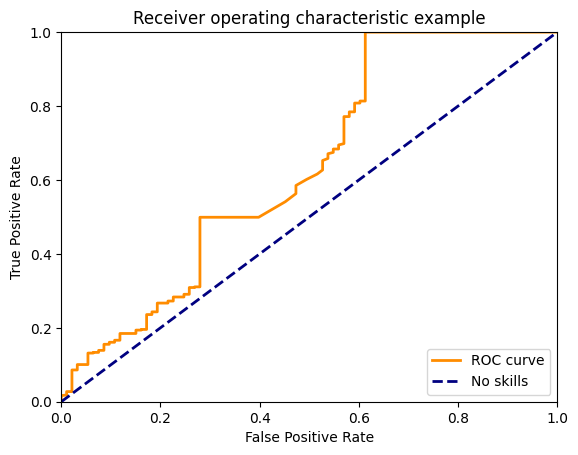

In [18]:
fpr, tpr, _ = roc_curve(y_score=bb_mia_test_probs, y_true=bb_mia_test_labels)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", linewidth =2, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linewidth =2, linestyle="--", label='No skills')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [19]:
target_labels = np.concatenate((y_train[attack_train_size:], y_test[attack_test_size:]))
results = get_roc_for_fpr(attack_proba=bb_mia_test_probs, attack_true=bb_mia_test_labels, targeted_fpr=0.01, target_model_labels=target_labels)
for v, fpr, tpr, threshold in results:
    print(f'Class {v}: {tpr=:.4f}: {fpr=:.4f}: {threshold=:.4f}')

Class 0.0: tpr=0.0330: fpr=0.0000: threshold=0.8794
Class 1.0: tpr=0.0000: fpr=0.0000: threshold=inf


## Safe SVM Model

In [21]:
C = 10
# 1.6
# 4.1
gamma = 1.6
clf3 = SafeSVC(C=C, gamma=gamma)
clf3.fit(X_train_scaled, np.ravel(y_train,order="c"))
c3 = clf3.predict(X_test_scaled)
p3 = clf3.predict_proba(X_test_scaled)

In [22]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, c3)*100)
print("Precision:", metrics.precision_score(y_test, c3)*100)
print("Recall:", metrics.recall_score(y_test, c3)*100)
print("F1-score:", metrics.f1_score(y_test, c3)*100)

Accuracy: 46.774193548387096
Precision: 48.86363636363637
Recall: 44.329896907216494
F1-score: 46.486486486486484


In [252]:
# clf3.save(name="testSaveSVC.pkl")
# clf3.preliminary_check()
# clf3.request_release(path="testSaveSVC", ext="pkl")
# target_json = os.path.normpath("testSaveSVC/target.json")
# with open(target_json, "r") as f:
#     print(f.read())
directory = './SVM_safe'
filename = os.path.join(directory, "model2.pkl")
print("Saving model to " + filename)
with open(filename, "wb") as file:
    pickle.dump(clf3, file)

Saving model to ./2\model2.pkl


### Attack

In [253]:
def generate_report(
    # data_processing_filename,
    # data_processing_function_name,
    # dataset_filename,
    directory,
    target_model,
    attack_results,
    target_filename,
    outfile,
    X_train, X_test, y_train, y_test,
):  # pylint: disable=too-many-locals, disable=too-many-arguments
    """Generate report based on target model."""

    print()
    print("Acting as TRE...")
    print(
        "(when instructions on how to recreate the dataset have been provided by the researcher)"
    )
    print(directory)
    print()

    # Read in the model supplied by the researcher
    filename = os.path.join(directory, target_model)
    print("Reading target model from " + filename)
    with open(filename, "rb") as f:
        target_model = pickle.load(f)

    # x_train, x_test, Y_train, Y_test = process_dataset(X_train, X_test, y_train, y_test)

    # Wrap the model and data in a Target object
    target = Target(model=target_model)
    target.add_processed_data(X_train, y_train, X_test, y_test)

    # TRE calls request_release()
    print("===> now running attacks implicitly via request_release()")
    target_model.request_release(path=directory, ext="pkl", target=target)

    print(f"Please see the files generated in: {directory}")

    # Generate a report indicating calculated disclosure risk
    text_report = GenerateTextReport()
    text_report.process_attack_target_json(
        os.path.join(directory, attack_results),
        target_filename=os.path.join(directory, target_filename),
    )

    text_report.export_to_file(
        output_filename=os.path.join(directory, outfile), move_files=True
    )

    print("Results written to " + str(os.path.join(directory, outfile)))


In [254]:
def run_user_story(release_config: dict):
    """Main method to parse arguments and then invoke report generation."""

    generate_report(
        # release_config["data_processing_filename"],
        # release_config["data_processing_function_name"],
        # release_config["dataset_filename"],
        release_config["training_artefacts_dir"],
        release_config["target_model"],
        release_config["attack_results"],
        release_config["target_results"],
        release_config["outfile"],
        X_train_scaled, X_test_scaled, y_train, y_test,
    )



Acting as TRE...
(when instructions on how to recreate the dataset have been provided by the researcher)
./2

Reading target model from ./2\model2.pkl
===> now running attacks implicitly via request_release()


INFO:_check_and_update_dataset:new ytrain has values and counts: (array([0, 1]), array([567, 527], dtype=int64))
INFO:_check_and_update_dataset:new ytest has values and counts: (array([0, 1]), array([89, 97], dtype=int64))


attack worst_case, metadata {'experiment_details': {'n_reps': 10, 'reproduce_split': [5, 25, 36, 49, 64, 81, 100, 121, 144, 169], 'p_thresh': 0.05, 'n_dummy_reps': 1, 'train_beta': 1, 'test_beta': 1, 'test_prop': 0.5, 'n_rows_in': 1094, 'n_rows_out': 186, 'training_preds_filename': None, 'test_preds_filename': None, 'output_dir': './2', 'report_name': 'attack_results', 'include_model_correct_feature': False, 'sort_probs': True, 'mia_attack_model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'mia_attack_model_hyp': {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 5}, 'attack_metric_success_name': 'P_HIGHER_AUC', 'attack_metric_success_thresh': 0.05, 'attack_metric_success_comp_type': 'lte', 'attack_metric_success_count_thresh': 5, 'attack_fail_fast': False, 'attack_config_json_file_name': None, 'target_path': None}, 'attack': 'WorstCase attack', 'global_metrics': {'null_auc_3sd_range': '0.4028 -> 0.5972', 'n_sig_auc_p_vals': 0, 'n_sig_auc_p_vals_corrected': 

INFO:lr-scenario:Training shadow models
INFO:lr-scenario:Trained 0 models
INFO:lr-scenario:Trained 10 models
INFO:lr-scenario:Trained 20 models
INFO:lr-scenario:Trained 30 models
INFO:lr-scenario:Trained 40 models
INFO:lr-scenario:Trained 50 models
INFO:lr-scenario:Trained 60 models
INFO:lr-scenario:Trained 70 models
INFO:lr-scenario:Trained 80 models
INFO:lr-scenario:Trained 90 models
INFO:lr-scenario:Computing scores for train rows
INFO:lr-scenario:Computing scores for shadow rows
INFO:lr-scenario:Finished scenario
INFO:reporting:Starting reports, pdf report name = ./2\attack_results.pdf, json report name = ./2\attack_results.json
INFO:reporting:Wrote pdf report to ./2\attack_results.pdf and json report to ./2\attack_results.json
INFO:aia:Starting reports, pdf report name = ./2\attack_results.pdf, json report name = ./2\attack_results.json


attack lira, metadata {'experiment_details': {'n_shadow_models': 100, 'p_thresh': 0.05, 'output_dir': './2', 'report_name': 'attack_results', 'training_data_filename': None, 'test_data_filename': None, 'training_preds_filename': None, 'test_preds_filename': None, 'target_model': None, 'target_model_hyp': None, 'attack_config_json_file_name': None, 'n_shadow_rows_confidences_min': 10, 'shadow_models_fail_fast': False, 'target_path': None}, 'global_metrics': {'PDIF_sig': 'Not significant at p=0.05', 'AUC_sig': 'Significant at p=0.05', 'null_auc_3sd_range': '0.4312868175323611 -> 0.5687131824676389'}, 'attack': 'LIRA Attack'}


INFO:aia:Wrote pdf report to ./2\attack_results.pdf and json report to ./2\attack_results.json


attack attribute, metadata {'experiment_details': {'output_dir': './2', 'report_name': 'attack_results', 'n_cpu': 11, 'attack_config_json_file_name': None, 'target_path': None}, 'attack': 'Attribute inference attack'}
Please see the files generated in: ./2
Results written to ./2\summary2.txt


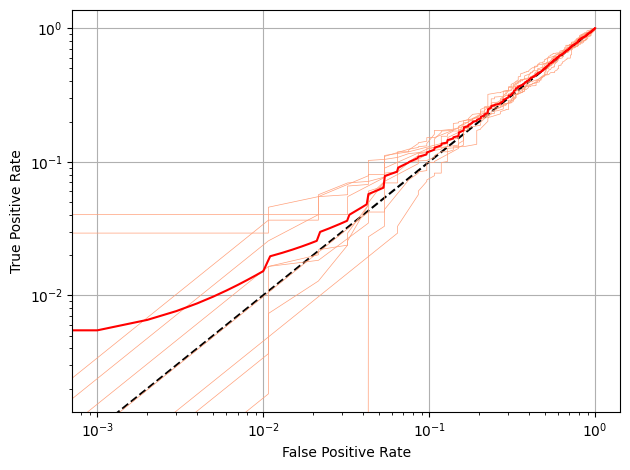

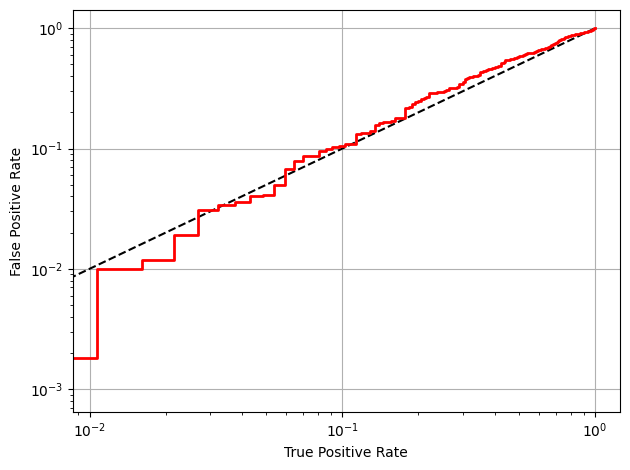

In [255]:
config = {
    'user_story': 2,
    'dataset_filename': 'C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv',
    'target_model': "model2.pkl",
    'outfile': "summary.txt",
    'attack_results': "attack_results.json",
    'training_artefacts_dir': "./SVM_safe",
    'target_results': "target.json",
    'data_processing_filename': './data_processing_researcher.py',
    'data_processing_function_name': 'process_dataset'
}

run_user_story(config)

### AR Toolbox MI Attack

In [33]:
art_classifier = ScikitlearnSVC(cl)

attack = MembershipInferenceBlackBoxRuleBased(art_classifier)

# infer attacked feature
inferred_train = attack.infer(X_train_scaled, y_train)
inferred_test = attack.infer(X_test_scaled, y_test)

# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

TypeError: Model must be of type sklearn.svm.SVC or sklearn.svm.LinearSVC. Found type <class 'scikeras.wrappers.KerasClassifier'>

In [38]:
from art.estimators.classification import SklearnClassifier
cl = SklearnClassifier(model= clf3.svc)


NotImplementedError: Kernel 'precomputed' not yet supported.

## XGBoost Model

### XGBoost Hyperparameter Optimisation

In [ ]:
space={'max_depth': hp.quniform("max_depth", 1, 60, 1),
        'gamma': hp.quniform ('gamma', 1,10,1),
        'alpha' : hp.quniform('alpha', 1,10,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,20),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 20),
        'n_estimators' : hp.quniform('n_estimators', 0, 5000,10),
        'learning_rate' : hp.uniform('learning_rate', 0.0001, 1)
        #,'k' : hp.quniform('k', 10, 280,1)
    }

def objective(space):
    clf=XGBClassifier(
                    n_estimators = int(space['n_estimators']),
                    max_depth = int(space['max_depth']),
                    gamma = int(space['gamma']),
                    alpha = int(space['alpha']),
                    min_child_weight=space['min_child_weight'],
                    colsample_bytree=space['colsample_bytree'],
                    scale_pos_weight=space['scale_pos_weight'],
                    learning_rate=space['learning_rate'],
                    eval_metric="error")

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation,
            #early_stopping_rounds=10,
            verbose=False)

    pred = clf.predict(X_test)
    #accuracy = accuracy_score(y_test, pred>0.5)
    f = f1_score(y_test, pred) #, average='macro'
    print("SCORE:", f)
    return {'loss': -f, 'status': STATUS_OK }


trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

In [42]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'alpha': 7.0, 'colsample_bytree': 0.7409841388776411, 'gamma': 7.0, 'learning_rate': 0.05627575371409634, 'max_depth': 25.0, 'min_child_weight': 9.928514810785389, 'n_estimators': 1710.0, 'scale_pos_weight': 9.484710447338873}


### Final XGBoost Model & Evaluation

In [ ]:
XGBmodel = XGBClassifier(alpha=int(best_hyperparams['alpha']),
                      colsample_bytree=best_hyperparams['colsample_bytree'],
                      gamma=int(best_hyperparams['gamma']),
                      learning_rate=best_hyperparams['learning_rate'],
                      max_depth=int(best_hyperparams['max_depth']),
                      min_child_weight=best_hyperparams['min_child_weight'],
                      n_estimators=int(best_hyperparams['n_estimators']),
                      scale_pos_weight=best_hyperparams['scale_pos_weight'],
                      eval_metric='error')

XGBmodel.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test,y_test)])
predictions = XGBmodel.predict(X_test)

In [86]:
y_pred = XGBmodel.predict(X_test)
predictions = [round(value) for value in y_pred]

In [103]:
f = f1_score(y_test, y_pred)
print("SCORE:", f)

SCORE: 0.9207920792079207


In [106]:
confusion_matrix = confusion_matrix(y_test.to_numpy().astype(int), y_pred)
confusion_matrix

TypeError: ignored

## Neural Network

In [53]:
object_cols = X_train.select_dtypes(include=['object']).columns
float_cols = X_train.select_dtypes(include=['float64']).columns

object_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

float_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('obj', object_transformer, object_cols),
        ('float', float_transformer, float_cols)
    ])

transformed_features = preprocessor.fit_transform(X_train)
y_one = to_categorical(y_train)

In [54]:
X_1, Xval, y_1, yval = train_test_split(
    transformed_features, y_one, test_size=0.3, shuffle=True, random_state=12345
  )

In [107]:
tf.random.set_seed(12345)

initializer = tf.keras.initializers.GlorotUniform(seed=42)

n_classes = 2

input_data = Input(shape=X_1.shape[1:])
x = Dense(128, activation="relu", kernel_initializer=initializer)(input_data)
x = Dense(512, activation="relu", kernel_initializer=initializer)(x)
x = Dense(512, activation="relu", kernel_initializer=initializer)(x)
x = Dense(128, activation="relu", kernel_initializer=initializer)(x)
x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
output = Dense(n_classes, activation="softmax", kernel_initializer=initializer)(x)

model = Model(inputs=input_data, outputs=output)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/100
31/31 [==============================] - 1s 25ms/step - loss: 16.1156 - accuracy: 0.7320 - val_loss: 22.1382 - val_accuracy: 0.8085
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 32.4761 - accuracy: 0.6980 - val_loss: 25.9209 - val_accuracy: 0.7416
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 23.1685 - accuracy: 0.7203 - val_loss: 13.4224 - val_accuracy: 0.7842
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 13.0524 - accuracy: 0.7386 - val_loss: 11.5927 - val_accuracy: 0.7508
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 18.4520 - accuracy: 0.7150 - val_loss: 27.7902 - val_accuracy: 0.6778
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 13.1202 - accuracy: 0.7464 - val_loss: 6.8810 - val_accuracy: 0.8298
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 14.1826 - accuracy: 0.7072 - val_loss: 39.5494 - val_accuracy: 

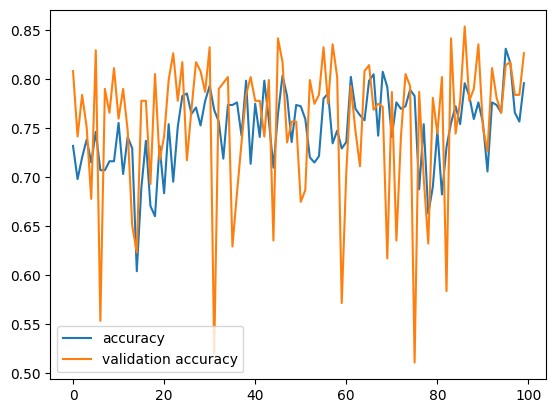

24/24 [==============================] - 0s 5ms/step
model training  report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.87       394
           1       0.92      0.75      0.83       371

    accuracy                           0.85       765
   macro avg       0.86      0.85      0.85       765
weighted avg       0.86      0.85      0.85       765



In [66]:
epochs = 100
batch_size = 25

r_DP = model.fit(
    X_1,
    y_1,
    validation_data=(Xval, yval),
    epochs=epochs,
    batch_size=batch_size,
)
if r_DP == None:
    print("You have chosen to exit. Reset relevant parameter values then re-run fit().")
else:
    plt.plot(r_DP.history["accuracy"], label="accuracy")
    plt.plot(r_DP.history["val_accuracy"], label="validation accuracy")
    plt.legend()
    plt.show()
    #ypred = safeModel.predict(X)
    y_pred = model.predict(X_1)
    ylabels = np.argmax(y_1, axis=1)
    ypredlabels = np.argmax(y_pred, axis=1)
    print(f"model training  report:\n {classification_report(ylabels,ypredlabels,zero_division=1)}")

## Saving Models

In [116]:
SVM_Baseline_Model = clf
XGB_Baseline_Model = XGBmodel
NN_Baseline_Model = model

SVM_Baseline_filename = os.path.join('/content/drive/MyDrive/Privacy-Project', "SVM_Baseline_model.pkl")
print("Saving model to " + SVM_Baseline_filename)
with open(SVM_Baseline_filename, "wb") as file:
    pickle.dump(SVM_Baseline_Model, file)

XGB_Baseline_filename = os.path.join('/content/drive/MyDrive/Privacy-Project', "XGB_Baseline_model.pkl")
print("Saving model to " + XGB_Baseline_filename)
with open(XGB_Baseline_filename, "wb") as file:
    pickle.dump(XGB_Baseline_Model, file)

NN_Baseline_filename = os.path.join('/content/drive/MyDrive/Privacy-Project', "NN_Baseline_model.pkl")
print("Saving model to " + NN_Baseline_filename)
with open(NN_Baseline_filename, "wb") as file:
    pickle.dump(NN_Baseline_Model, file)

Saving model to /content/drive/MyDrive/Privacy-Project/SVM_Baseline_model.pkl
Saving model to /content/drive/MyDrive/Privacy-Project/XGB_Baseline_model.pkl
Saving model to /content/drive/MyDrive/Privacy-Project/NN_Baseline_model.pkl


In [117]:
np.savetxt(os.path.join('/content/drive/MyDrive/Privacy-Project', "x_train.txt"), X_train, fmt="%d")
np.savetxt(os.path.join('/content/drive/MyDrive/Privacy-Project', "y_train.txt"), y_train, fmt="%d")
np.savetxt(os.path.join('/content/drive/MyDrive/Privacy-Project', "x_test.txt"), X_test, fmt="%d")
np.savetxt(os.path.join('/content/drive/MyDrive/Privacy-Project', "y_test.txt"), y_test, fmt="%d")

# Baseline Attacks

## XGBoost Attack

In [122]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00


In [136]:
from art import config
from art.estimators.classification import BlackBoxClassifier
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical
from art.utils import load_dataset, get_file, compute_accuracy
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack
from art.utils import load_mnist
from art.estimators.classification import XGBoostClassifier
import xgboost as xgb

In [164]:
def get_adversarial_examples(x_train, y_train, num_classes):

    # Create and fit XGBoost model
    #num_round = 10
    #param = {'objective': 'multi:softprob', 'metric': 'multi_logloss', 'num_class': num_classes}
    #train_data = xgb.DMatrix(x_train, label=y_train)
    #evallist = [(train_data, 'eval'), (train_data, 'train')]
    #model = xgb.train(param, train_data, num_round, evallist)

    model = XGBClassifier(alpha=int(best_hyperparams['alpha']),
                      colsample_bytree=best_hyperparams['colsample_bytree'],
                      gamma=int(best_hyperparams['gamma']),
                      learning_rate=best_hyperparams['learning_rate'],
                      max_depth=int(best_hyperparams['max_depth']),
                      min_child_weight=best_hyperparams['min_child_weight'],
                      n_estimators=int(best_hyperparams['n_estimators']),
                      scale_pos_weight=best_hyperparams['scale_pos_weight'],
                      eval_metric='error')

    model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test,y_test)])

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(model=model, nb_features=x_train.shape[1], nb_classes=10) #10
    #art_classifier =

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False,
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

In [175]:
def get_data(x_train, y_train, num_classes):
    #x_train, y_train = load_iris(return_X_y=True)
    #x_train = X_train
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] *= 2
    x_train[:, 1][y_train == 2] *= 2
    x_train[:, 0][y_train == 0] -= 3
    x_train[:, 1][y_train == 2] -= 2

    x_train[:, 0] = (x_train[:, 0] - 4) / (9 - 4)
    x_train[:, 1] = (x_train[:, 1] - 1) / (6 - 1)

    return x_train, y_train

In [139]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes):

    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1], s=20,
                                 zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z_proba = model.predict(xgb.DMatrix(np.c_[xx.ravel(), yy.ravel()]))
        Z_proba = Z_proba[:, i_class].reshape(xx.shape)
        im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   vmin=0, vmax=1)
        if i_class == num_classes - 1:
            cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
            plt.colorbar(im, ax=axs[i_class], cax=cax)

        # Plot adversarial samples
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].scatter(x_2_0, x_2_1, zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')

In [176]:
num_classes = 2
X_train, y_train = get_data(X_train, y_train, num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(X_train, y_train, num_classes)
plot_results(model, X_train, y_train, x_train_adv, num_classes)

InvalidIndexError: ignored